In [10]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from src.PLS.utils import sims_graphs
from matplotlib.lines import Line2D
import pandas as pd
from src.PLS.utils import threshold_scheduler
from src.PLS.ABC import ABC_rejection
from src.PLS.ABC import sum_sqrt_sq_distance
import scipy as sp

In [11]:
#Reality
import numpy as np
from src.PLS.baseSIR import no_ext_sir
from src.PLS.baseSIR import timed_sir
from decimal import Decimal, ROUND_UP
import time

distance_measure_array = ["sum_sq","sum_sqrt_sq","mixed","rinf"]
dis = distance_measure_array[1]
I0 = ["","_I1"][1]

if I0 == "":
    X0 = [900, 100, 0]
elif I0 == "_I1":
    X0 = [999,1,0]
seed = 1
gamma = 1
beta = 3
mu = 0
tstep = 0.05
test_time = 100
rng = np.random.default_rng(1)
tmax = float(Decimal(tstep) * (Decimal(timed_sir(X0, mu, beta, gamma, test_time, rng) )/ Decimal(tstep)).quantize(1,rounding=ROUND_UP))
rng = np.random.default_rng(seed)
start_time = time.time()
reality_1 = no_ext_sir(X0, mu, beta, gamma, tmax, tstep, rng)
print(f"Reality took {time.time() - start_time} seconds to run!")
factor=100

Reality took 0.17510104179382324 seconds to run!


In [12]:
Typ = "simple_I0"
siz = "10"
seed = 1912
sim_scen = ""
beta_controls = [1]
n_runs = 1000
rng = np.random.default_rng(1912)

In [13]:
#for i in range(len(beta_controls)):
distro_seeds = [1.5,2,2.25,2.5,3]
distance_func = lambda x:sum_sqrt_sq_distance(x[0:312,:],reality_1/100)
plot_dict = {}
plot_dict["Runs"] = []
plot_dict["T"] = []
for distro_seed in distro_seeds:
    distro = [distro_seed]*n_runs
    output_dictionary = sims_graphs(distro, Typ, siz, seed, sim_scen, beta_controls[:],ext=True)
    dis_array = []
    for n in range(n_runs):
        run = output_dictionary["Runs"][n][0:312,:]
        dis_array.append(distance_func(run))
    dis_df = pd.DataFrame(dis_array,columns=["Distance"])
    sort_res = dis_df.sort_values(by="Distance")
    temp = sort_res.iloc[0:int(len(sort_res.index) / (100/100))]
    crit_val = temp.iloc[-1][0]
    index = [dis_array <= crit_val][0]
    all_runs = output_dictionary["Runs"][0:n_runs]
    filtered_runs = [i for indx,i in enumerate(all_runs) if index[indx]]
    plot_dict["Runs"].append(np.mean(np.array([j for j in filtered_runs]), axis=0))

C:\Users\ollie\AppData\Local\Temp\ipykernel_27076\439871330.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  crit_val = temp.iloc[-1][0]


In [14]:
trajs = 1
iterations = 18
I0_fittings = {}
I0_fittings["10"] = {}

In [15]:
for i in range(1,trajs+1):
                total_traj = np.genfromtxt(f"../../../Cluster/fittings/fit10s/Traj_{i}_1_10b_I1.csv",delimiter=",")
                print(".",end="")
                for j in range(2,iterations +1):
                    temp = np.genfromtxt(f"../../../Cluster/fittings/fit10s/Traj_{i}_{j}_10b_I1.csv",delimiter=",")
                    total_traj = np.append(temp,total_traj,axis=0)
                I0_fittings["10"][f"{i}"] = total_traj

.

In [16]:
distance_df = pd.DataFrame(I0_fittings["10"]["1"], columns=["Beta","Distance"])
reference = [0.1,0.5,1,2,5,10,15,20]
threshold_schedule = threshold_scheduler(distance_df, reference)
print(len(threshold_schedule))

8


C:\Users\ollie\AppData\Local\Temp\ipykernel_27076\845634034.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


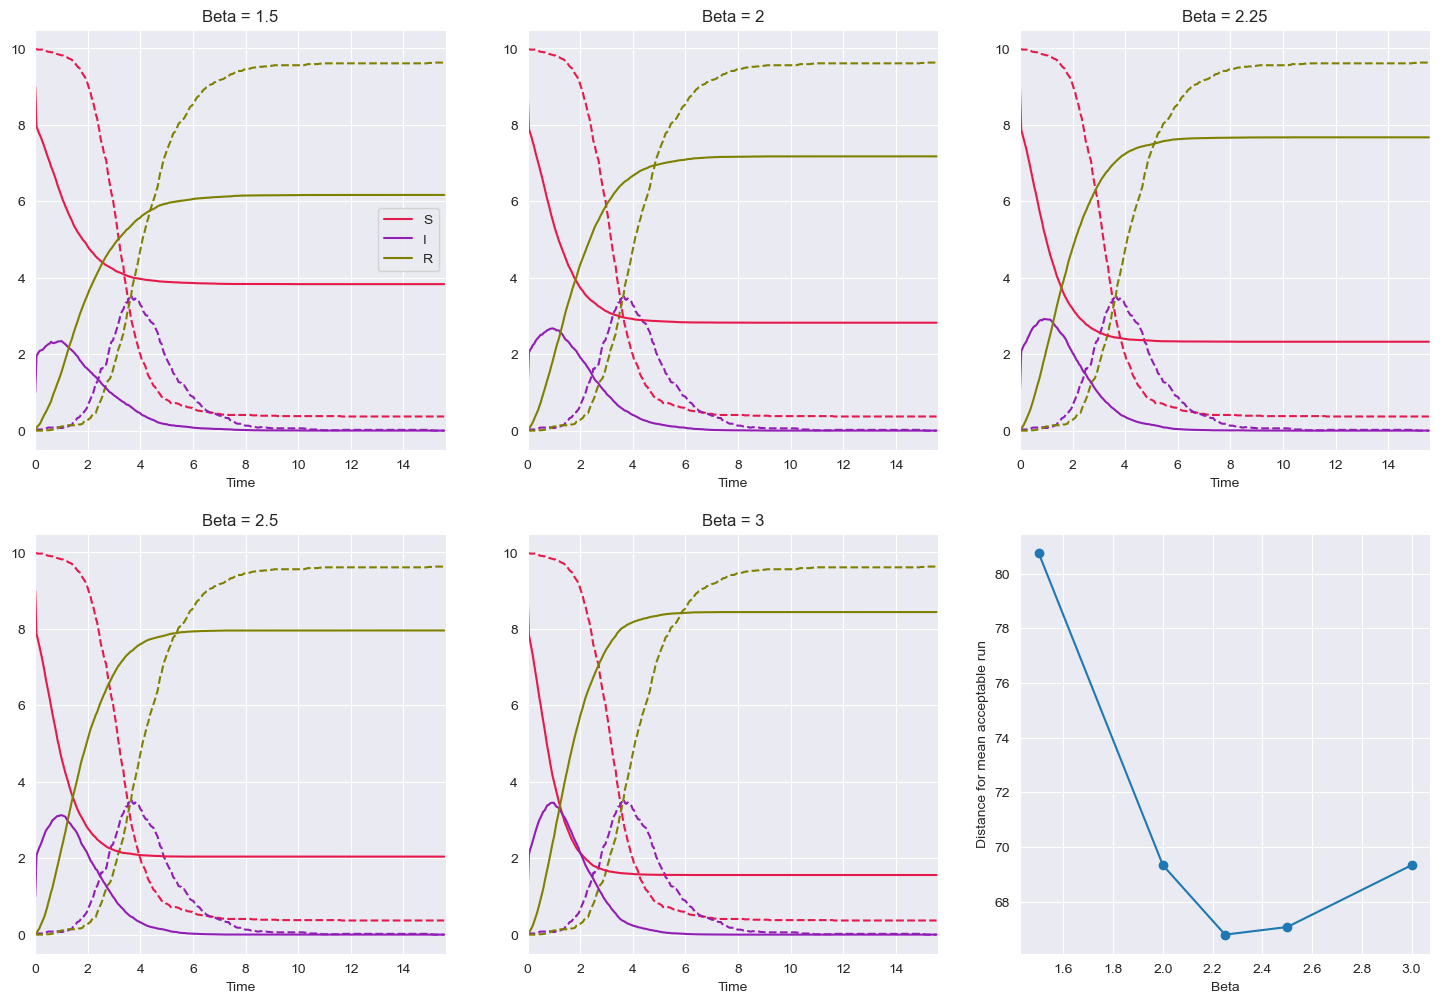

In [17]:
fig, ax0 = plt.subplots(figsize = (18,12), nrows=2,ncols =3)
ax0 = ax0.flatten()
times = np.arange(0,tmax,0.05)
run_times = np.arange(0,tmax,tstep)
distances = []
colours = ['#e6194b','#911eb4',"#808000"]
for i in range(0,5):
    ax0[i].set_prop_cycle('color', colours)
    ax0[i].plot(run_times, np.array(reality_1)/factor, linestyle = "--")
    ax0[i].plot(times,np.array(plot_dict["Runs"][i])[0:len(times),0], alpha = 1, label = "S")
    ax0[i].plot(times,np.array(plot_dict["Runs"][i])[0:len(times),1], alpha = 1, label = "I")
    ax0[i].plot(times,np.array(plot_dict["Runs"][i])[0:len(times),2], alpha = 1, label = "R")
    ax0[i].set_xlabel("Time")
    ax0[i].set_xlim(0,tmax)
    ax0[i].set_title(f"Beta = {distro_seeds[i]}")
    distances.append(sum_sqrt_sq_distance(plot_dict["Runs"][i][0:312,:],reality_1/100))
ax0[5].scatter(distro_seeds,distances)
ax0[5].plot(distro_seeds,distances)
ax0[5].set_xlabel("Beta")
ax0[5].set_ylabel("Distance for mean acceptable run")
#ax0[4].plot(np.arange(1,10.01,0.01),distance_df.groupby("Beta").quantile(.2))
ax0[0].legend()


#ax0[4].set_xlabel("Beta")
#ax0[4].set_ylabel("Distance for 5th Quantile of runs")
fig.show()

In [18]:
#cols = sns.color_palette("rocket", n_colors=10)
#for i in range(len(threshold_schedule)):
#        thresh = ABC_rejection(threshold_schedule[i], I0_fittings["10"]["1"])
#        ploted = pd.DataFrame(thresh, columns=["Beta", "Counts"])
#        bet_dis = ploted.groupby("Beta").count()
#        plot_bet_dis = bet_dis[bet_dis["Counts"] != 0]
#        max_scale = max(plot_bet_dis["Counts"])
#        plot_bet_dis["Counts"] = plot_bet_dis["Counts"] / max_scale
#        area = np.trapz(plot_bet_dis["Counts"],dx=0.01)
#        plot_bet_dis["Counts"] = plot_bet_dis["Counts"] / area
#        spline = sp.interpolate.CubicSpline(plot_bet_dis.index, plot_bet_dis["Counts"])
#        ax0[5].scatter(bet_dis.index, plot_bet_dis["Counts"], label=f"Threshold= {reference[i]}% accepted",alpha=0.25)
#        ax0[5].plot(plot_bet_dis.index, spline(plot_bet_dis.index))
#ax0[5].legend()
#ax0[5].set_xlabel("Beta")
#ax0[5].set_ylabel("Posterior Probability Distribution")
#ax0[5].axvline(2.5, color="maroon")